In [ ]:
import csv
import time
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx import tree
from datetime import datetime
from prefixspan import PrefixSpan
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import euclidean_distances

In [ ]:
input_path = '/input/path'
output_path = '/output/path'

temp = pd.DataFrame()
event_event_id = []

smart_meters = pd.read_csv(input_path + 'Events.csv', delimiter=';')
smart_meters = smart_meters.sort_values('EVENTTIMESTAMP')
smart_meters['date'] = pd.to_datetime(smart_meters['EVENTTIMESTAMP']).dt.date
smart_meters['date'] = pd.to_datetime(smart_meters['date'])

# Splitting data based on date
for date in smart_meters['date'].unique():
    temp = smart_meters[smart_meters['date'] == date]
    temp.to_csv(output_path + 'data_'+ str(date) +'.csv', index=False)

#exctrating event IDs and event names
smart_meters_1=smart_meters_[['EVENTID','EVENTDATA']]
smart_meters_1.drop_duplicates(inplace=True)
smart_meters_1.sort_values('EVENTID', inplace=True)
smart_meters_1.to_csv(output_path + 'event_event_id.csv', index=False)

# Preprocessing data
source_output = os.listdir(output_path)

for data in ['data_2017-05-', 'data_2017-06-', 'data_2017-07-', 'data_2017-08-']:
    start_time = time.time()
    output = pd.DataFrame()
    for file in source_output:
        if file.startswith(data) and file.endswith('.csv'):
            print(file)
            dataset = pd.read_csv(output_path + file)
            dataset['EVENTID'] = dataset['EVENTID'].apply(lambda x:str(x))
            temp = []

            for name, group in dataset.groupby('DEVICEID'):
                start_date_time = pd.to_datetime(group['EVENTTIMESTAMP'].values[0])
                stop_date_time = pd.to_datetime(group['EVENTTIMESTAMP'].values[-1])

                duration = (stop_date_time - start_date_time).total_seconds()

                event_type_seq = ','.join(group['EVENTDATA'])
                event_type_seq_id = ','.join(group['EVENTID'])

                temp.append([start_date_time,        #0
                             stop_date_time,         #1
                             name,                   #2
                             round(duration,3),      #3 
                             event_type_seq,         #4
                             event_type_seq_id,      #5
                             start_date_time.date(), #6 
                            ])

            output = [output, pd.DataFrame(temp)] #
            output = pd.concat(output, ignore_index=True)

    output = pd.DataFrame({'date':output[6],'start_date_time':output[0],'stop_date_time':output[1], 'device_id':output[2],\
                           'device_uptime':output[3], 'event_type_seq':output[4], 'event_type_seq_id':output[5]}) 
    
    print()
    print('Number of device IDs: ', len(output.device_id.unique()))
    print('Number of sequential dataset records: ', len(output))

    x = 0
    for row in output['event_type_seq']:
        x = x + len(row.split(','))

    print('Number of events: ', x)
    stop_time = time.time()
    print('Execution time: ' + repr(round((stop_time - start_time),0)) + ' sec')
    output.to_csv(output_path + data[5:12] +'_.csv', index=False)
    print()

# sampling the dataset    
source_output = os.listdir(output_path)
device = []
dataset = pd.DataFrame()
sample_size = 30        # number of samples 
sample_date = '2017-05' # month of sampling

for file in source_output:
    if file.startswith(sample_date) and file.endswith('.csv'): 
        dataset = pd.read_csv(output_path + file, delimiter=',')
        
for name, group in dataset.groupby('device_id'):
    if len(group['device_id']) > 30:
        device.append(name)

sample_devices = np.random.choice(device, sample_size,  replace=False)
sample_dataset_may = dataset[dataset['device_id'].isin(sample_devices)]
for name, group in sample_dataset_may.groupby('date'):
    print(name, len(group))
sample_dataset_may.to_csv(output_path + 'sample_dataset_' + name[:7] + '.csv' )

# Extracting frequent sequential patterns using PrefixSpan
# PrefixSpan is adpoted from Chuancong Gao' GitHub repository available at https://github.com/chuanconggao/PrefixSpan-py 

source_output = os.listdir(output_path)

for file in source_output:
    if file.startswith('sample_dataset_' + sample_date) and file.endswith('.csv'):
        print(file)
        dataset = pd.read_csv(output_path + file)
        
        for date, group_date in dataset.groupby('date'):
            print(date)
            selected_patterns = []
            unmatched_patterns = []
            all_patterns = pd.DataFrame()
            start_time = time.time()
            for device, group_device in group_date.groupby('device_id'):
               
                len_dataset = (len(group_device))
                event_seq = pd.DataFrame(group_device,columns=['event_type_seq_id'])
                
                dataset_seq = []
                for values in event_seq.values.tolist():
                    for value in values:
                        dataset_seq.append(value.split(','))
                ps = []
                ps = PrefixSpan(dataset_seq)
                ps.minlen = 3
                ps.maxlen = 7
                prefix_results = ps.frequent(1)
                prefix_results.sort()
                prefix_results.sort(key=lambda tup: len(tup[1]), reverse=True)
                prefix_results = pd.DataFrame(prefix_results,columns=['support','pattern'])
                
                mataced_patterns_count = 0
                unmatched_patterns_count = 0
                number_of_matches = 0

                temp_dataset = group_device
                temp_dataset['pattern'] = '-'

                for row in prefix_results.pattern:
                    pattern = ','.join(row)

                    num_matches = len(group_device[group_device['event_type_seq_id'].str.contains(pattern)]) #

                    if (pattern != ''):
                        if (num_matches > 0): #
                            temp_dataset['pattern'] = np.where(temp_dataset['event_type_seq_id'].str.contains(pattern)
                                                               & ~temp_dataset['pattern'].str.contains(pattern), 
                                                               temp_dataset['pattern'].astype(str) + pattern + '-', 
                                                               temp_dataset['pattern']) #


                            mataced_patterns_count += 1
                            selected_patterns.append([device, date, pattern, len(pattern.split(',')), num_matches])
                    elif (num_matches == 0): #
                        unmatched_patterns.append([device, date, pattern, len(pattern.split(',')), 0]) #
                        unmatched_patterns_count += 1 #

                all_patterns = [all_patterns, temp_dataset] #
                all_patterns = pd.concat(all_patterns, ignore_index=True) #
            
            selected_patterns = pd.DataFrame(selected_patterns)
            selected_patterns = pd.DataFrame({'device':selected_patterns[0], 'date':pd.to_datetime(selected_patterns[1]), 
                                              'pattern':selected_patterns[2],'pattern_len':selected_patterns[3], 
                                              'frequency':selected_patterns[4]})

            selected_patterns.to_csv(output_path + 'selected_patterns_' + date + '.csv', index=False)

            if len(unmatched_patterns) > 0 :
                unmatched_patterns = pd.DataFrame(unmatched_patterns)
                unmatched_patterns = pd.DataFrame({'device':unmatched_patterns[0],'date':pd.to_datetime(unmatched_patterns[1]), 
                                                   'pattern':unmatched_patterns[2],'pattern_len':unmatched_patterns[3], 
                                                   'frequency':unmatched_patterns[4]})
                unmatched_patterns.to_csv(output_path + 'unmatched_patterns' + date + '.csv', index=False)
            
            all_patterns.to_csv(output_path + 'frequent_patterns_' + date + '.csv', index=False)
            stop_time = time.time()
            print('Execution time: ' + repr(round((stop_time - start_time),0)) + ' sec')
            print()



source_output = os.listdir(output_path)
selected_patterns = pd.DataFrame()
frequent_patterns = pd.DataFrame()

# Merging selected patterns
for file in source_output:
    if file.startswith('selected_patterns_' + sample_date) and file.endswith('.csv'):
        print(file)
        dataset = pd.read_csv(output_path + file)
        selected_patterns = [selected_patterns, dataset]
        selected_patterns = pd.concat(selected_patterns, ignore_index=True)
selected_patterns.to_csv(output_path + 'selected_patterns_' + sample_date + '_.csv', index=False)

# Merging all extracted patterns
for file in source_output:
    if file.startswith('frequent_patterns_' + sample_date) and file.endswith('.csv'):
        print(file)
        dataset = pd.read_csv(output_path + file)
        frequent_patterns = [frequent_patterns, dataset]
        frequent_patterns = pd.concat(frequent_patterns, ignore_index=True) 
frequent_patterns.to_csv(output_path + 'frequent_patterns_' + sample_date + '_.csv', index=False)


# Calculating the frequency of each selected pattern
selected_patterns = pd.read_csv(output_path + 'selected_patterns_' + sample_date + '_.csv', delimiter=',')
i = 0
mfsp_id = []
mPattern_id = []
mfsp_freq = []

tmp_selected_patterns = selected_patterns[(selected_patterns['frequency'] >= 1) == True]
total_freq = sum(tmp_selected_patterns['frequency'])
print('Total number of frequent sequential patterns:', total_freq)

for name, group in selected_patterns.groupby('pattern'):
    if len(group['date'].unique()) >= 1 and len(name.split(',')) > 1:
        if sum(group['frequency']) >= 1:
            mPattern_id.append([name, sum(group['frequency'])])
            mfsp_freq.append(sum(group['frequency']))
            name = map(int, name.split(','))
            mfsp_id.append(list(name))

            i += 1
print('Total number of unique frequent sequential patterns:',i)
mPattern_id.sort(key=lambda tup: tup[1], reverse=True)
print(mPattern_id)
print()
print(mfsp_id)

In [ ]:
# Levenshtein Distance (edit distance) algorithm source code
# The code is adpoted from: https://www.geeksforgeeks.org/dynamic-programming-set-5-edit-distance/
# Written by Bhavya Jain.
def editDistDP(str1, str2):
    
    # Added by the "Shahrooz Abghari" for normalization purposes
    ############################################################
    m = len(str1)
    n = len(str2)
    if m < n:
        m, n = n, m
        str1, str2 = str2, str1
    ############################################################
    # Create a table to store results of subproblems
    dp = [[0 for x in range(n+1)] for x in range(m+1)]
    
    # Fill d[][] in bottom up manner
    for i in range(m+1):
        for j in range(n+1):
 
            # If first string is empty, only option is to
            # isnert all characters of second string
            if i == 0:
                dp[i][j] = j    # Min. operations = j
                
            # If second string is empty, only option is to
            # remove all characters of second string
            elif j == 0:
                dp[i][j] = i    # Min. operations = i
                
            # If last characters are same, ignore last char
            # and recur for remaining string
            elif str1[i-1] == str2[j-1]:
                dp[i][j] = dp[i-1][j-1]
                
            # If last character are different, consider all
            # possibilities and find minimum
            else:
                dp[i][j] = 1 + min(dp[i][j-1],        # Insert
                                   dp[i-1][j],        # Remove
                                   dp[i-1][j-1])    # Replace
               
    return float(dp[m][n])/m # normalize the result by dividing it with the length of the longest pattern

In [ ]:
def editDist_matrix(X, Y):
    test = []
    test = [[editDistDP(X[i], Y[j]) for j in range(len(Y))] for i in range(len(X))]
    a = pd.DataFrame(test)
    return a

# Calculating the similarity between patterns
start_time = time.time()
print ("LD is started!")
mfsp_id_matrix_editDist = editDist_matrix(mfsp_id, mfsp_id)
print('Execution time: ' + repr(round((time.time() - start_time),0)) + ' sec')

mfsp_id_matrix_editDist.to_csv(output_path+'sample_1_s_matrix')
mfsp_distance_matrices = [mfsp_id_matrix_editDist]

# Clustering the patterns, using AffinityPropagation 
i = 0
distance_matrices = [mfsp_id_matrix_editDist]
distances = ['LD']
af_labels = []
af_n_clusters_centroid = []
af_n_clusters = []
af_silhouette_avg = []

for distance_matrix in distance_matrices:
    af = AffinityPropagation().fit(distance_matrix)
    cluster_centers_indices = af.cluster_centers_indices_
    af_labels.append(af.labels_)
    af_n_clusters_centroid.append(cluster_centers_indices)
    af_n_clusters.append(len(cluster_centers_indices))
    af_silhouette_avg.append(silhouette_score(distance_matrix, af_labels[i], metric='euclidean'))
    
    print('---------', distances[i],'---------')
    print('Estimated number of clusters: %d' % af_n_clusters[i])
    print("Silhouette Coefficient: %f" % af_silhouette_avg[i])
    i +=1

# Calculating the similarity between exemplars
af_centroid_patterns = []

for distance in range(len(distances)):
    temp = []
    for item in af_n_clusters_centroid[distance]:
        temp.append(mfsp_id[item])
    af_centroid_patterns.append(temp)
print(af_centroid_patterns)


for i in range(len(distances)):
    print('---------', distances[i],'---------')
    start_time = time.time()
    print ("LD is started!")
    centroids_matrix_editDist = editDist_matrix(af_centroid_patterns[i], af_centroid_patterns[i])
    print('Execution time: ' + repr(round((time.time() - start_time),0)) + ' sec')
    break

# Building Minimum Spanning Tree
G = nx.Graph()
G.population={}

weighted_edges = []
for i in range(len(centroids_matrix_editDist)):
    for j in range(len(centroids_matrix_editDist)):
        weighted_edges.append((i,j,centroids_matrix_editDist[i][j]))
        
for i in range (af_n_clusters[0]):
    freq_ = 0
    for k, v in zip(af_labels[0], mfsp_freq):
        if k == i:
            freq_ += v
    G.population[i] = freq_

G.add_nodes_from(range(len(centroids_matrix_editDist)))
G.add_weighted_edges_from(weighted_edges)

mst = nx.minimum_spanning_tree(G)
mst_ = mst
pos = nx.layout.kamada_kawai_layout(mst_)

/opt/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


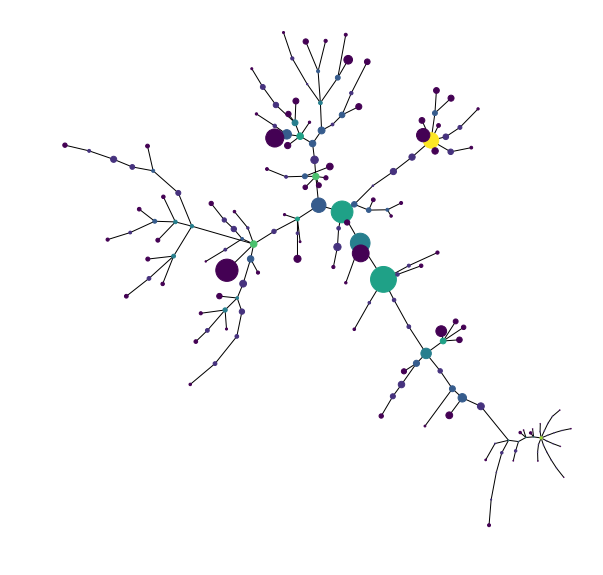

       edge  weight
4    (0, 9)     1.0
5  (0, 107)     1.0


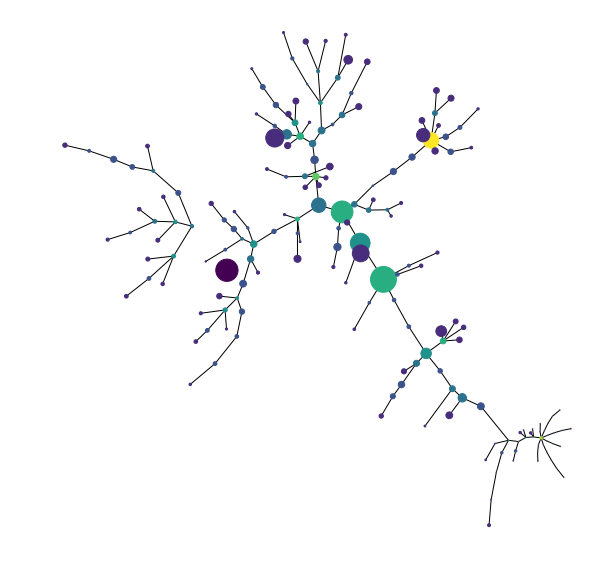

In [24]:
# Plotting the MST before and after cutting the longest edge
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(mst_, pos, with_labels=False, font_size = 8,
        node_size=[G.population[v]/5 for v in G],
        node_color = [float(mst_.degree(v)) for v in mst_])
plt.savefig('tree_1.pdf', format='pdf', dpi=300)
plt.show()

removed_edge = []
mst_edge_weight = []

for item in mst_.edges(data=True):
    mst_edge_weight.append([(item[0], item[1]), item[2]['weight']])

mst_edge_weight = pd.DataFrame(mst_edge_weight)
mst_edge_weight = pd.DataFrame({'edge':mst_edge_weight[0], 'weight':mst_edge_weight[1]})

for name, group  in mst_edge_weight.groupby('weight'):
    if name == mst_edge_weight['weight'].max():
        print(group)
        for item in group['edge']:
            removed_edge.append(item[0])
            removed_edge.append(item[1])
            mst_.remove_edge(item[0],item[1])

fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(mst_, pos, with_labels=False, font_size = 8,
        node_size=[G.population[v]/5 for v in G],
        node_color = [float(mst_.degree(v)) for v in mst_])
plt.savefig('tree_2.pdf', format='pdf', dpi=300)
plt.show()

In [37]:
# Output each sub-trees nodes and their total number of patterns
cluster_area = []

for i in range (af_n_clusters[0]):
    freq_ = 0
    for k, v in zip(af_labels[0], mfsp_freq):
        if k == i:
            freq_ += v   
    cluster_area.append(freq_/100)

a = set()
b=[]

for i in range(len(centroids_matrix_editDist)):
    if len(list(mst_.neighbors(i))) == 0:
         b.append({i})
    else:
        a.add(i)
        for j in mst_.neighbors(i):
            a.add(j)
            for k in mst_.neighbors(j):
                a.add(k)
        if a not in b:
            b.append(a)
        a=set()
# print(b)
print()

c = set()
d = []
for i in range(len(b)):
    for j in range(len(b)):
        if len(b[i]&b[j]) > 0:
            c = c.union(b[i])
            c = c.union(b[j])
    if len(d) > 0:
        for item in d:
            flag = False
            if len(c&item) > 0:
                flag = True
                d.append(c.union(item))
                d.remove(item)
        if flag == False:
            d.append(c)
    else:
        d.append(c)
    c = set()

for item in d: 
    a=0
    for i in item:
        a+=int(cluster_area[i]*100)
    print(item, a)
    print()


{9} 2473

{107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126} 1514

{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183} 28050



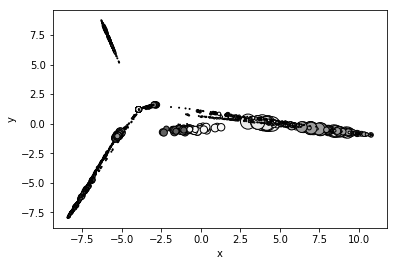

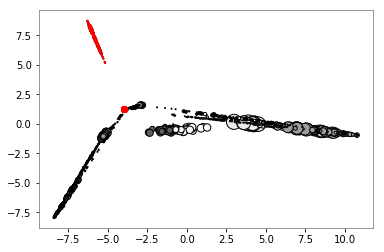

In [39]:
# Plotting the results and showing the outliers (in red) using PCA
%matplotlib inline

pca_mfsp = PCA(n_components=2).fit(mfsp_id_matrix_editDist)
pca_mfsp_2d = pd.DataFrame(pca_mfsp.transform(mfsp_id_matrix_editDist))
pca_mfsp_2d = pd.DataFrame({'x':pca_mfsp_2d[0],'y':pca_mfsp_2d[1]})
pca_mfsp__ = pca_mfsp.transform(mfsp_id_matrix_editDist)

mfsp_area = [((n)) for n in mfsp_freq]

label = pd.DataFrame({'label': af_labels[0]})
area = pd.DataFrame({'area': mfsp_area})
frame = pd.concat([pca_mfsp_2d, label, area], axis=1)

df_ = pd.DataFrame()
temp_ = pd.DataFrame()

# Choose the clusters of the smallest sub-trees (this need to be done manually)
for i in [9,107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]:
    temp_ = frame.loc[frame['label'] == i]
    df_ = [df_, temp_]
    df_ = pd.concat(df_, ignore_index=False)

df__ = frame[~frame.label.isin(df_.label)]    

fig, ax = plt.subplots()

frame.plot(kind='scatter', x='x', y='y', ax=ax, c=af_labels[0], s=mfsp_area, edgecolor='black')
plt.savefig('AP_LD_Feb_2018_.pdf', format='pdf', dpi=300)


fig, ax = plt.subplots()
frame.plot(kind='scatter', x='x', y='y', ax=ax, c=af_labels[0], s=mfsp_area, edgecolor='black')
df_.plot(kind='scatter', x='x', y='y', ax=ax, c='red', s=df_.area, alpha=1)

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_facecolor("white")
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')

plt.savefig('AP_LD_Feb_2018.pdf', format='pdf', dpi=300)
plt.show()

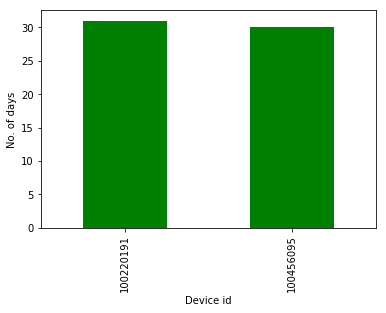

In [31]:
# Extracting the unexpected patterns from each cluster
unexpected_pattern=[]
for k, v in zip(frame.label, mfsp_id):
    if k in [9, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]:
        v_ =[]
        for item in v:
            v_.append(str(item))
        unexpected_pattern.append([','.join(v_),k])
len(unexpected_pattern)

# Output detected outliers
temp_ = []
anomaly = pd.DataFrame()
unexpected_pattern_index = []
anomaly_freq = []

k = 0
distances = ['LD']
clustering_alg = ['Affinity Propagation']
n_clusters_ = [af_n_clusters]
clusters_label = [af_labels]

for j in range(1):
    for i in range(len(distances)):
        print('##############################################################################')
        print('Clustering Algorithm: ', clustering_alg[j])
        print('Distance measure: ', distances[i])
#         print('Average Silhouette scoure for the clustering solution: ', silhouette_avg_[j][i])
        print('##############################################################################')
        print()
        
        all_patterns = pd.read_csv(output_path + 'frequent_patterns_2017_05.csv')

        anomaly = pd.DataFrame()
        count = n_clusters_[j][i]
        pattern_index = []
        
        print(count)
        anomaly_freq = []
        
        unexpected_pattern_ = pd.DataFrame(unexpected_pattern)
        unexpected_pattern_[0].str.len().sort_values().index
        unexpected_pattern_ = unexpected_pattern_.reindex(unexpected_pattern_[0].str.len().sort_values(ascending=False).index)

        for row, un_pattern in unexpected_pattern_.groupby([0], sort=False):
            print(row)
            temp_ = all_patterns
            temp_['pattern_'] = np.where(temp_['pattern'].str.contains(row), row, '+')
            if len(temp_[temp_['pattern_'] != '+']) > 0:
                temp_ = temp_[temp_['pattern_'] != '+']
                anomaly = [anomaly, temp_]
                anomaly = pd.concat(anomaly, ignore_index=True)
                all_patterns = all_patterns[all_patterns['pattern_'].str.contains(row) == False]


print(len(anomaly))
anomaly.to_csv(output_path + 'outlier_2017_05_.csv', index=False)

# Plotting detected outliers for each device 
pivot_anomaly=anomaly.pivot_table(index='device_id', aggfunc={'date':'count'})
pivot_anomaly.to_csv(output_path+'pivot_anomaly_1.csv')
pivot_anomaly.plot.bar(color=['g'], figsize=(6,4))
plt.ylabel('No. of days')
plt.xlabel('Device id')
plt.legend().set_visible(False)
plt.savefig(output_path + 'devices_with_issue.pdf', format ='pdf', dpi=300, bbox_inches='tight')